In [2]:
project_name = 'kornet'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob as glob
import pdb
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = f'{git_dir}/data'
results_dir = f'{git_dir}/results'
fig_dir = f'{git_dir}/figures'


sub_info = pd.read_csv(f'{data_dir}/sub_info.csv' )
#remove subjects with NaNs in code field
#sub_info = sub_info[~sub_info['code'].isna()]
#remove subjects with 1 in exclude field
sub_info = sub_info[sub_info['exclude'] != 1]


benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset',
    'vonecornet_s','cornet_s','voneresnet', 'vit','convnext','resnet50','resnext50','alexnet','vgg19', 'ShapeNet','SayCam']

benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam', 'vit','convnext']
conds = ['complete', 'perturbed','deleted']
model_conds = ['Outline','Pert','IC']
durations = [.3,.25, .2,.15,.1]
speed = ['intro','slow','slow','fast','fast']

age_groups = ['3yrold','4yrold','5yrold']


### Sumarize group info

In [98]:
#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 128
Number of subjects per age group:
age_group
3    38
4    45
5    45
dtype: int64
Number of subjects per condition:
cond
1    43
2    42
3    43
dtype: int64
Number of subjects per sex:
sex
F    65
M    63
dtype: int64
Mean age: 4.61453125
Age range: 3.05 - 5.95


### Create child summary files

In [101]:


sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt','imputed','top_speed'])

for sub in sub_info['sub']:

    sub_cond = sub_info[sub_info['sub']==sub]['cond'].values[0] -1 #subtract 1 because conditions are 1 2 3
    sub_file = glob(f'{data_dir}/{conds[sub_cond]}/{sub}_*.csv')
    #check if subfile is not empty
    if len(sub_file) != 0:
        to_impute = False #flag to check whether some data was imputed
        sub_file = sub_file[0]
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration'])['resp.corr'].mean().reset_index()
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration'])['resp.rt'].mean().reset_index()
        sem = sub_data.groupby(['Duration'])['resp.corr'].sem()
        sem = sem.reset_index()
        


        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc['Duration']
        temp_summary['imputed'] = 0

        temp_summary['sub'] = sub
        temp_summary['cond'] = conds[sub_cond]
        temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        temp_summary['age_group'] = np.floor(sub_info[sub_info['sub']==sub]['age'].values[0]).astype(str)[:-2] + 'yrold'
        temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #find fastest speed
        #this is reverse coded as duration
        top_speed = .3 - np.min(temp_summary['duration'])
        


        
        #loop through durations and check if there is data for each duration
        for dur in durations:
            
            if dur not in temp_summary['duration'].values:
                #add row for duration and fill with .5 - sem
                sem = sub_data['resp.corr'].sem()

                #add new row to temp_summary with .5 - sem for acc and np.nan for rt, all other values the same               
                temp_summary = pd.concat([temp_summary, 
                                         pd.DataFrame({'sub':[sub], 'cond':[conds[sub_cond]], 'age':[sub_info[sub_info['sub']==sub]['age'].values[0]],'age_group':[temp_summary['age_group'].values[0]],'sex': [sub_info[sub_info['sub']==sub]['sex'].values[0]],
                                                       'duration':[dur], 'acc':[.5 - sem], 'rt':[np.nan], 'imputed':[1]})])

                to_impute = True
        

        if to_impute == True:
            temp_summary['imputed'] = 1


        temp_summary['top_speed'] = top_speed
                   
        

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

        
        


    else:
        print(f'no file for {sub}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]
    
    
#save long format    
sub_summary.to_csv(f'{results_dir}/group_data/sub_summary_long.csv', index = False)






In [102]:
#create new sub_info with only subjects that have data
sub_info = sub_info[sub_info['sub'].isin(sub_summary['sub'])]

#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 126
Number of subjects per age group:
age_group
3    37
4    45
5    44
dtype: int64
Number of subjects per condition:
cond
1    42
2    42
3    42
dtype: int64
Number of subjects per sex:
sex
F    64
M    62
dtype: int64
Mean age: 4.617301587301587
Age range: 3.05 - 5.95


In [103]:
'''Convert to wide format for analysis'''

sub_summary_wide = sub_summary



#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]

#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 


#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)
#convert imputed to string
sub_summary_wide['imputed'] = sub_summary_wide['imputed'].astype(str)
#convert top_speed to string
sub_summary_wide['top_speed'] = np.round(sub_summary_wide['top_speed'],2).astype(str)


sub_summary_wide = sub_summary_wide.groupby(['sub','cond','age','age_group','duration','imputed','top_speed'])['acc'].mean().reset_index()
sub_summary_wide = sub_summary_wide.pivot_table(index = ['sub','cond','age','age_group','imputed','top_speed'], columns = 'duration', values = 'acc').reset_index()

#save wide format
sub_summary_wide.to_csv(f'{results_dir}/group_data/sub_summary_wide.csv', index = False)
#loop through and save seperate files for complete, perturbed, and deleted
for cond in conds:
    temp = sub_summary_wide[sub_summary_wide['cond']==cond]
    temp.to_csv(f'{results_dir}/group_data/sub_summary_{cond}.csv', index = False)

### Child Plotting func

In [8]:
from plotnine import *
def make_line_plot(summary, grouping, name):
    #in plotnine create line graph with x = duration, y = accuracy, fill = cond
    p = ggplot(summary, aes(x='factor(duration)', y='acc', fill=grouping, group = grouping)) + \
        geom_line(aes(color = grouping), stat = 'summary', size = 1, position = position_dodge(width=.5)) + \
        geom_linerange(aes(color = grouping),stat = 'summary', size = 1, position = position_dodge(width=.5)) + \
        geom_point( stat = 'summary', size = 3, position = position_dodge(width=.5)) + \
        scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) + \
        scale_color_manual(values = ['#808080','#ee7183', '#7398af']) + \
        xlab('Duration (s)') + ylab('Accuracy') + \
            theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 1) + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(size = 12),
                axis_text_y= element_text(size = 12),
                axis_title=element_text(size = 14),
                axis_line=element_line(), 
                panel_border=element_blank(),
                figure_size = (6, 6))+ \
                theme(legend_position = 'none') + \
                labs(fill='Condition') #+ ggtitle(f'{cond}')
        

    #save
    p.save(f'{fig_dir}/{name}.png', dpi = 300)
    print(p)


#### Make lineplots by age

Summary by condition


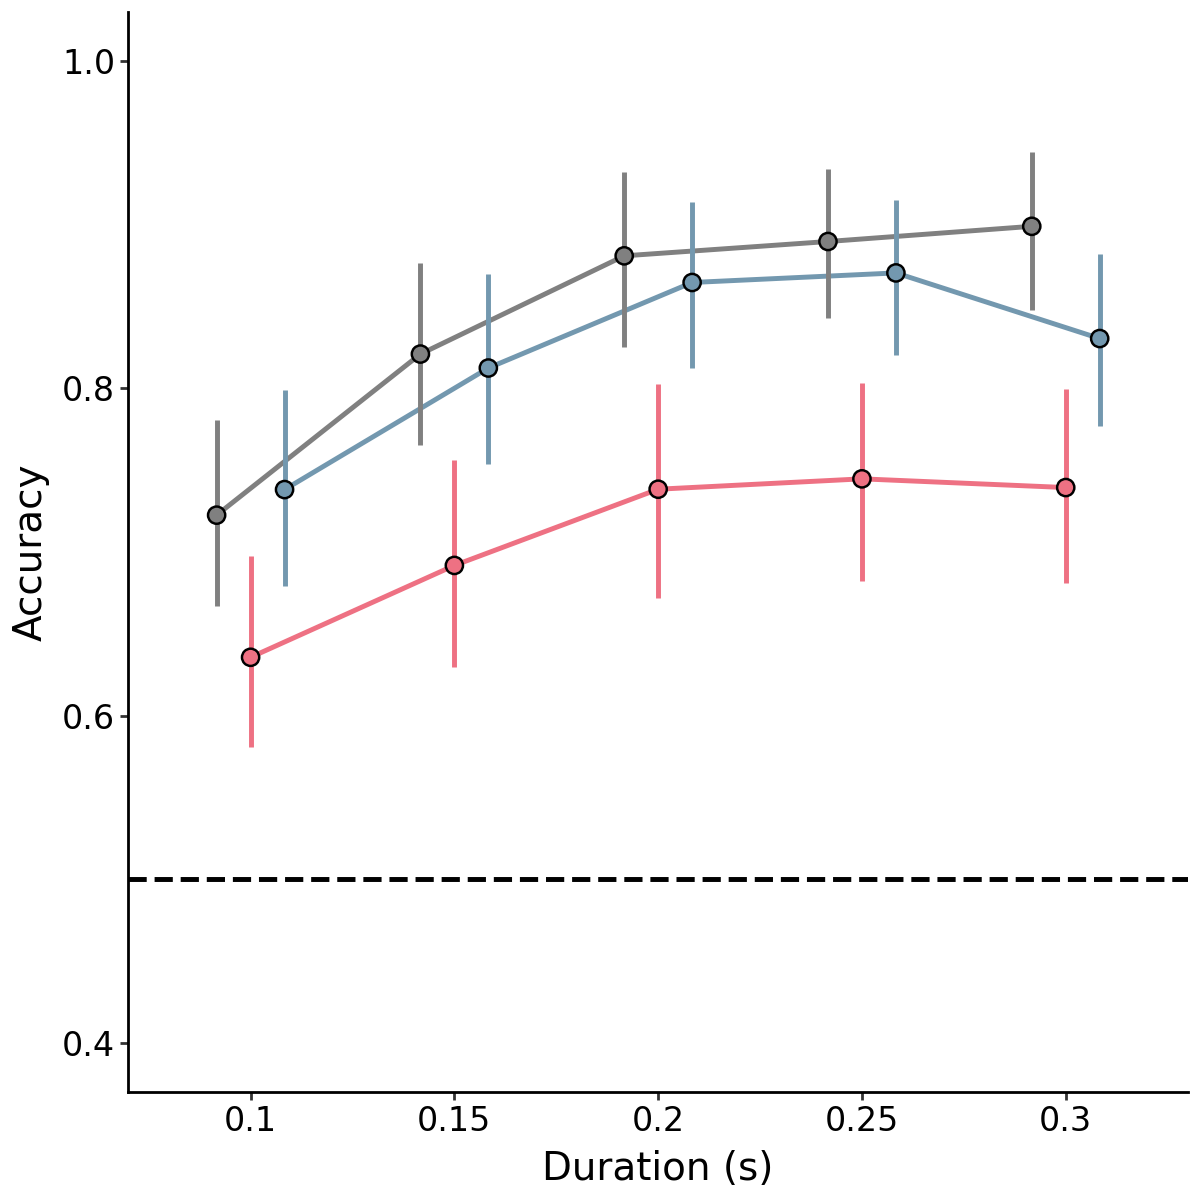


complete


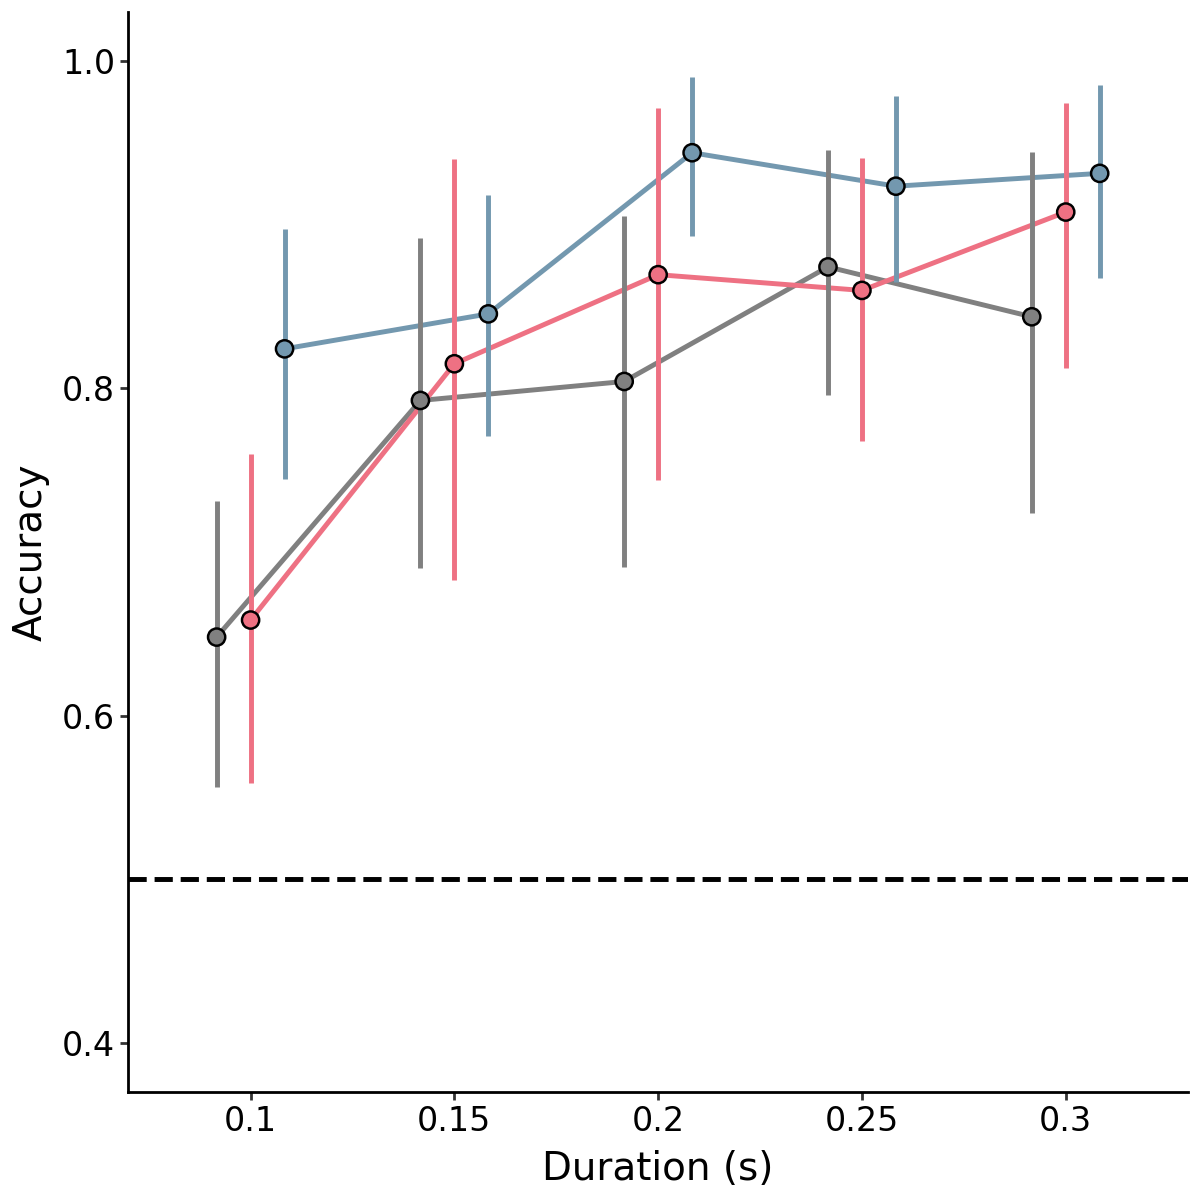


perturbed


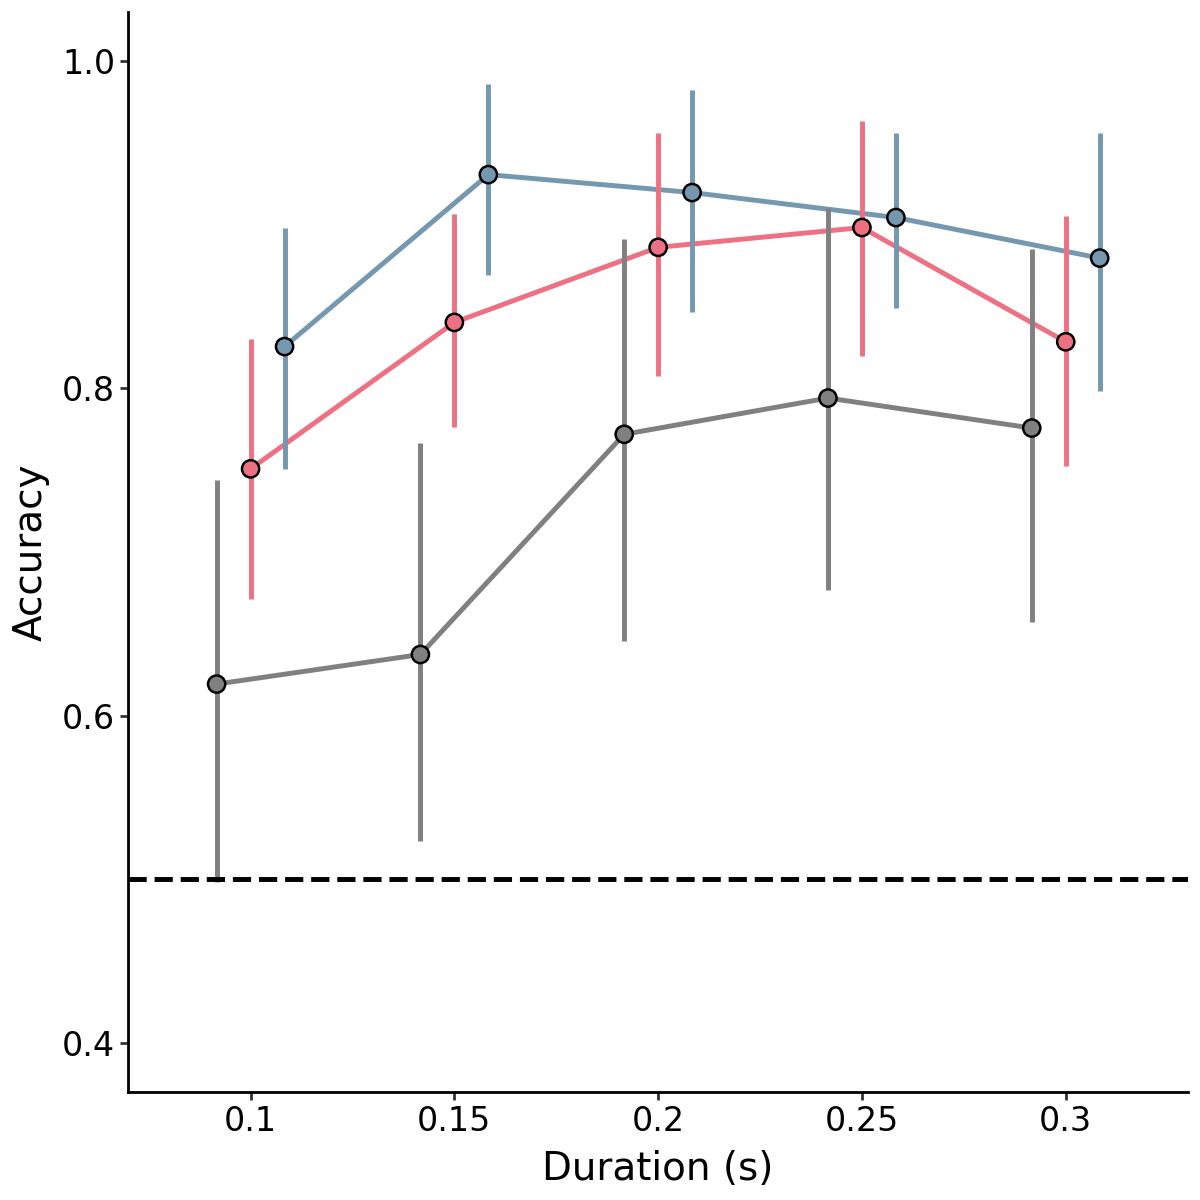


deleted


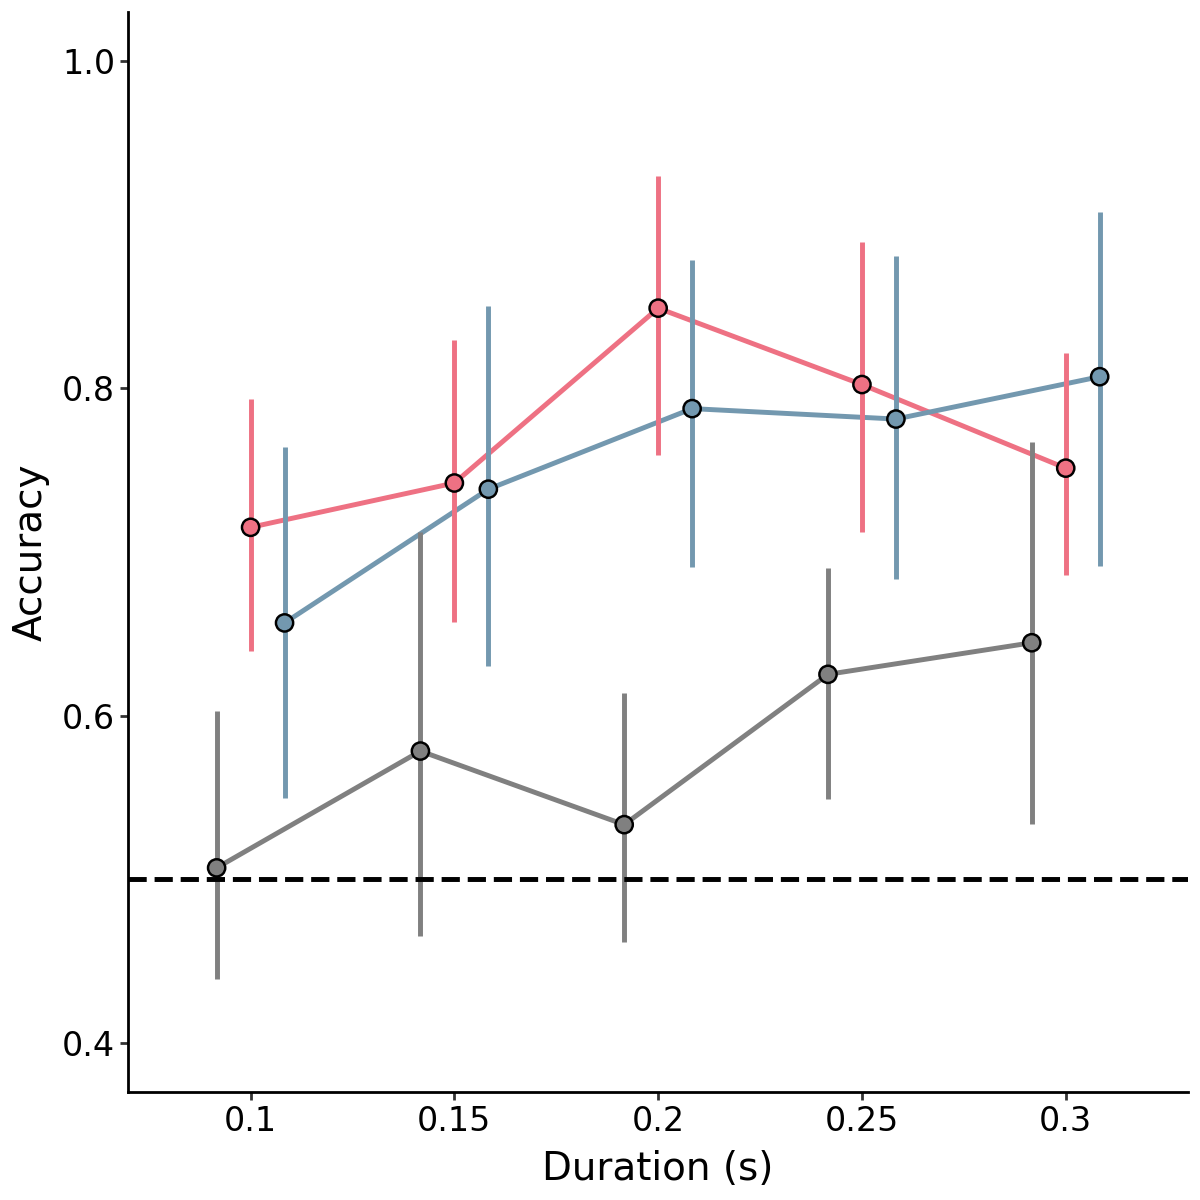

In [9]:
#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] != .35]

print('Summary by condition')
make_line_plot(sub_summary,'cond','summary_by_condition')


#loop through conds and make line plots
for cond in conds:
    print(cond)
    sub_summary_cond = sub_summary[sub_summary['cond'] == cond]
    make_line_plot(sub_summary_cond,'age_group', f'{cond}_by_age_group')






## Model analyses

In [4]:
''' model params'''

#model_arch = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam','convnext', 'vit']
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'ShapeNet','SayCam','convnext', 'vit']


colors = sns.light_palette("steelblue", 5)[-2:]  + sns.light_palette("seagreen", 5)[-2:] + \
    sns.light_palette("gold", 5)[-1:] + sns.light_palette("orange", 5)[-1:] + \
    sns.light_palette("violet", 5)[-1:] + sns.light_palette("purple", 5)[-1:] + \
        sns.light_palette("firebrick", 10)[-6:]


model_colors = sns.color_palette(colors).as_hex()
#model_arch = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam','convnext']
classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']
train_ns = [5, 10, 25, 50, 100, 150, 200, 250, 300]


#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] < .3]

#train_ns = [5, 10]

In [5]:
'''
Determine best performing version of each model and then compare across models and children
'''



for cond in model_conds:
    print(cond)
    full_summary = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc', 'ci','ci_low', 'ci_high'])    
    
    
    for model in model_arch:
        model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','ci_low','ci_high'])
        for classifier in classifiers:
        

            for train_n in train_ns:
                
                    model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                    if os.path.exists(model_file):
                        temp_df = pd.read_csv(model_file)

                        #groupby 
                        temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()

                        #calculate ci
                        temp_df_mean['ci'] = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].sem().reset_index()['acc']*1.96


                        #compute lower and upper CI
                        temp_df_mean['ci_low'] = temp_df_mean['acc'] - temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].sem().reset_index()['acc']*1.96
                        temp_df_mean['ci_high'] = temp_df_mean['acc'] + temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].sem().reset_index()['acc']*1.96

                        
                        
                        
                        model_df = pd.concat([model_df, temp_df_mean], axis = 0)
                    else:
                        print(f'no file for {model}_{classifier}_{train_n}_{cond}')

        #find best variation of current model
        best_model = model_df[model_df['acc'] == model_df['acc'].max()]
        #add best_model to full_summary
        full_summary = pd.concat([full_summary, best_model], axis = 0)


    for age in age_groups:
        for speed in ['fast', 'slow']:
            #extract sub data for age, cond, and speed
            temp_sub_summary = sub_summary[(sub_summary['age_group']==age) & (sub_summary['cond']==conds[model_conds.index(cond)])]

            #calculate mean acc
            acc = temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].mean()

            ci = temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].sem()*1.96

            #calculate CIs
            ci_low = acc - temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].sem()*1.96
            ci_high = acc + temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].sem()*1.96


            #compile data into list
            temp_df = [f'{age}_{speed}', '','',conds[model_conds.index(cond)], acc, ci, ci_low, ci_high]
            temp_summary = pd.DataFrame([temp_df], columns = full_summary.columns)
            #append ot full_summary
            full_summary = pd.concat([full_summary, temp_summary], axis = 0)

    #save
    full_summary.to_csv(f'{results_dir}/{cond}_model_comparison.csv', index = False)
                    

Outline
no file for vit_SVM_250_Outline
no file for vit_SVM_300_Outline
Pert
no file for vit_SVM_250_Pert
no file for vit_SVM_300_Pert
no file for vit_Ridge_300_Pert
IC
no file for vit_SVM_300_IC
no file for vit_Ridge_300_IC


Outline


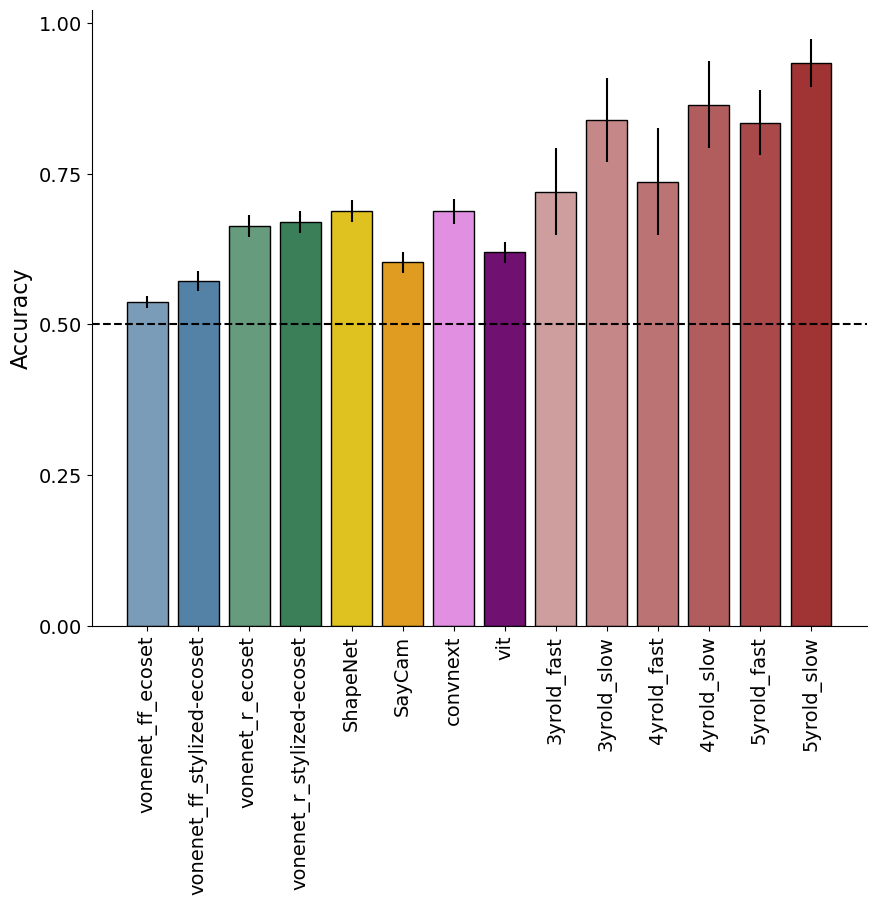

Pert


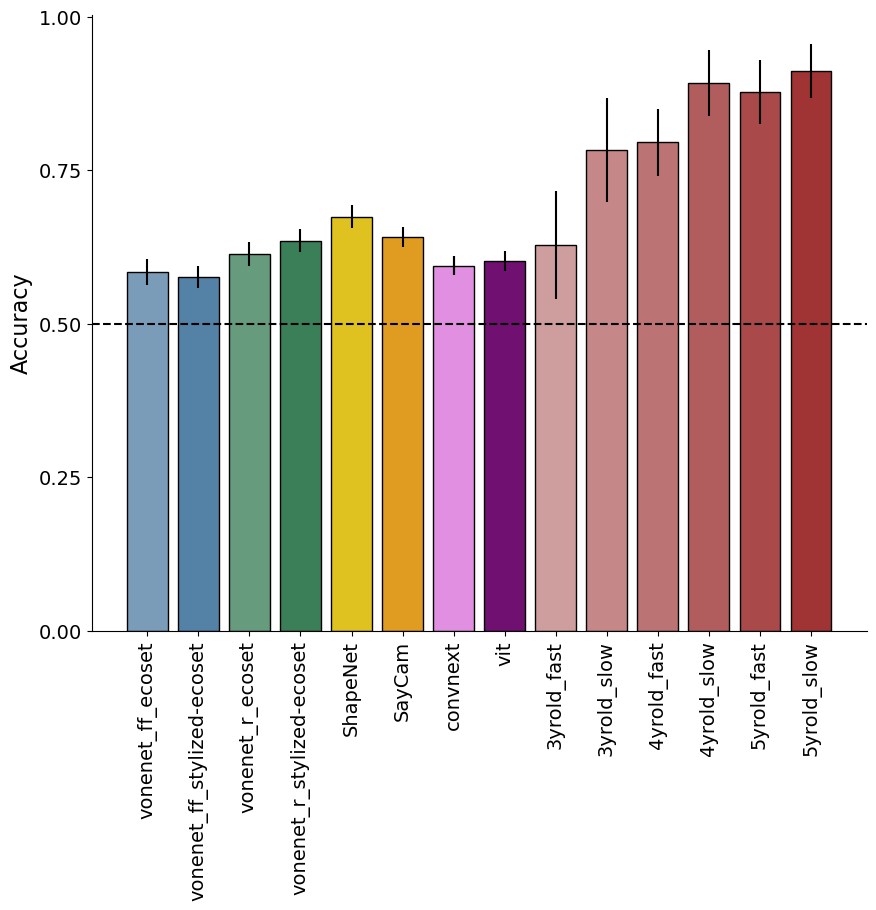

IC


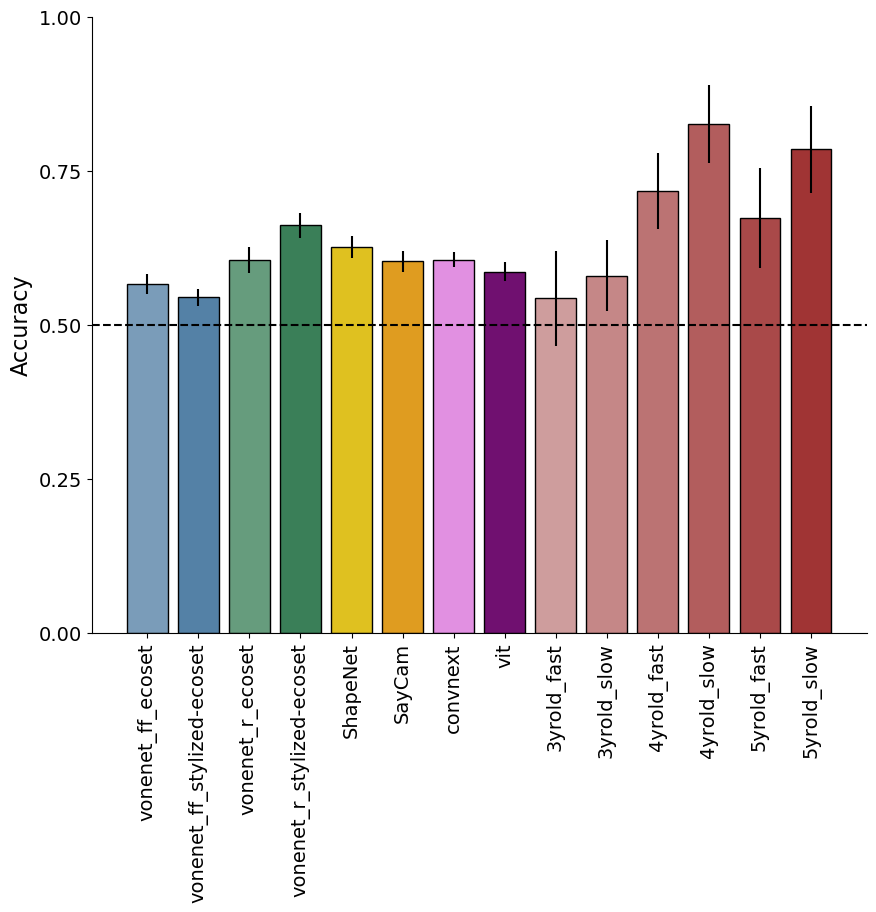

In [6]:
for cond in model_conds:
    print(cond)

    full_summary = pd.read_csv(f'{results_dir}/{cond}_model_comparison.csv')

    fig, ax = plt.subplots(figsize=(10,8))

    #Make bar plot with each model as a different color, and CIs for error bars
    sns.barplot(data = full_summary, x = 'model', y = 'acc', hue = 'model', dodge=False, palette=model_colors, edgecolor = 'k')

    #add error bars

    plt.errorbar(x = full_summary['model'], y = full_summary['acc'], yerr = full_summary['ci'], fmt = 'none', color = 'black', capsize = 0)

    #orient x labels
    plt.xticks(rotation=90)


    #put legend outside plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    #add dotted line at .5
    plt.axhline(y=.5, color='black', linestyle='--')

    #remove x axis label
    plt.xlabel('')

    #add y axis label, increae font size
    plt.ylabel('Accuracy', fontsize = 16)

    #increase font size of x axis labels
    plt.xticks(fontsize = 14)

    #increase font size of y axis labels
    plt.yticks(fontsize = 14)

    #set y-axis increments to .25
    plt.yticks(np.arange(0, 1.25, .25))

    #remove top and right spines
    sns.despine()

    #make left and bottom spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    #remove legend
    plt.legend().remove()
    
    #save
    plt.savefig(f'{fig_dir}/{cond}_model_comparison.png', dpi = 300, bbox_inches = 'tight')

    plt.pause(.001)


Outline
no file for vit_SVM_250_Outline
no file for vit_SVM_300_Outline


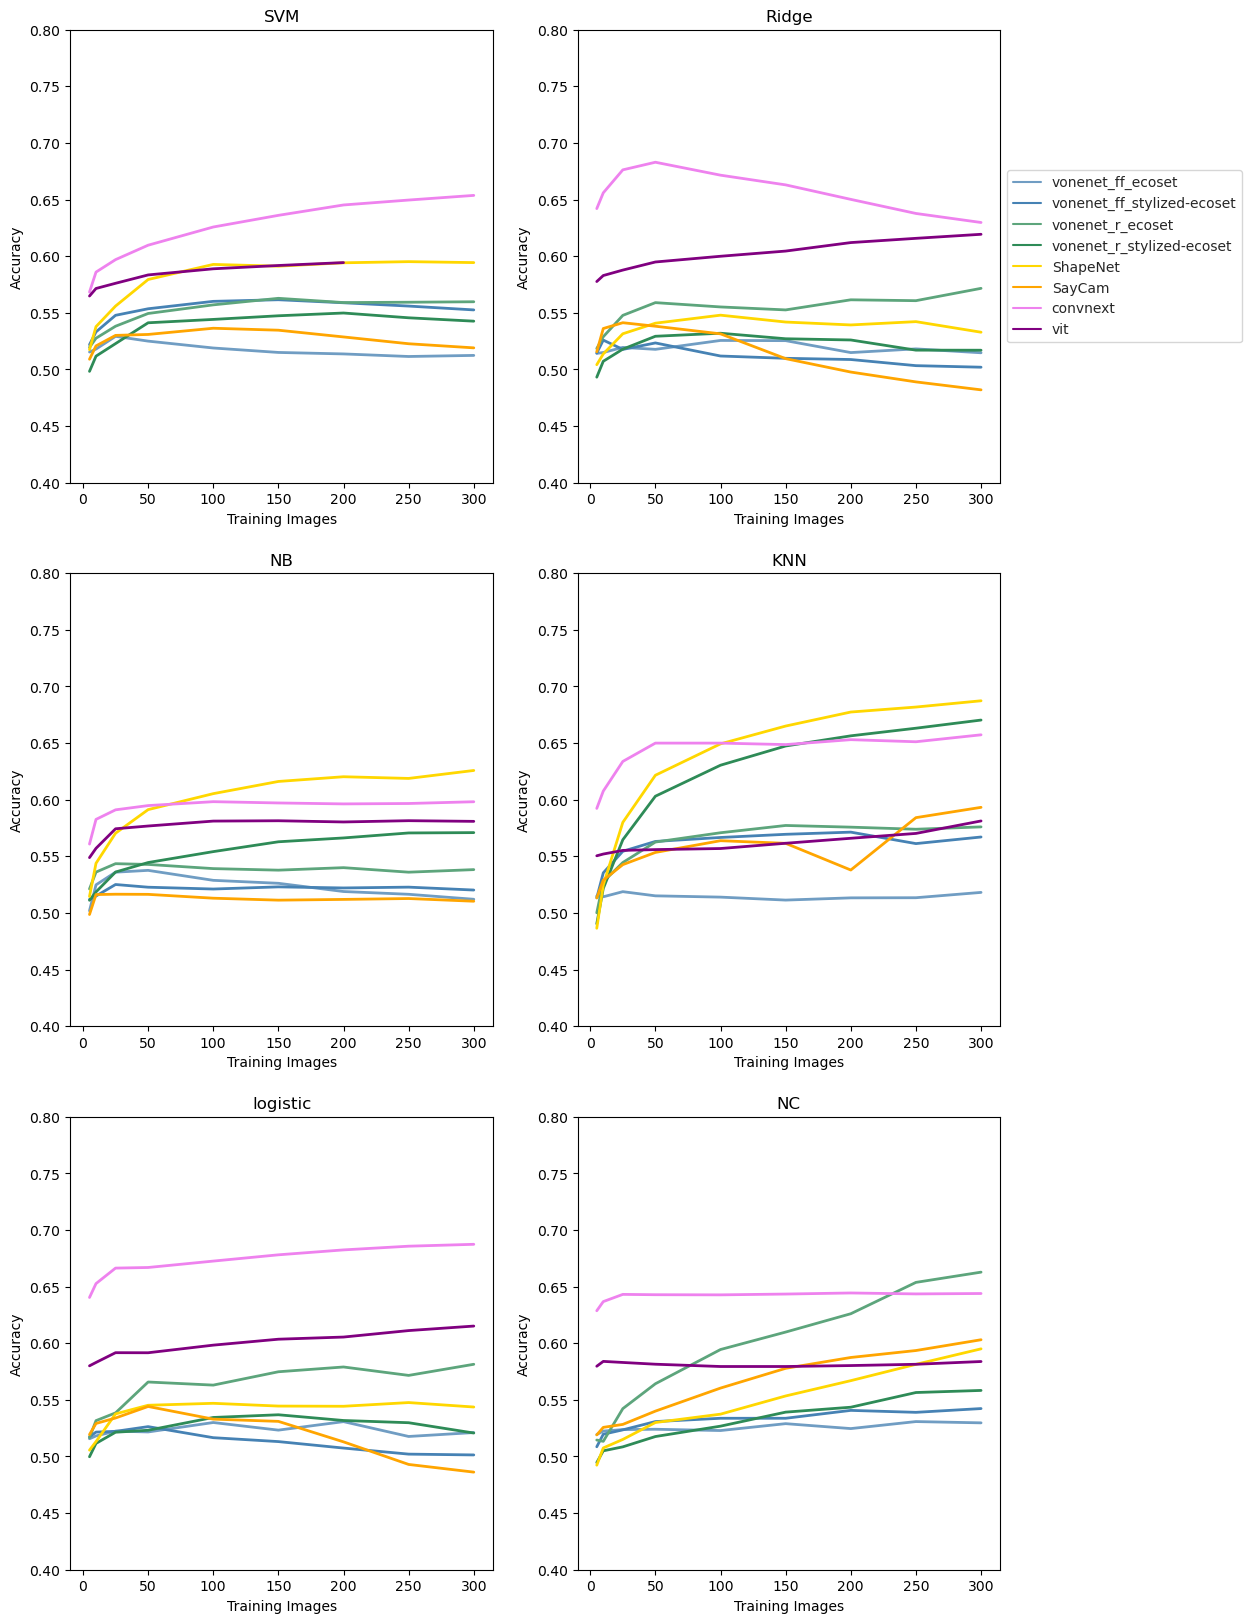

Pert
no file for vit_SVM_250_Pert
no file for vit_SVM_300_Pert
no file for vit_Ridge_300_Pert


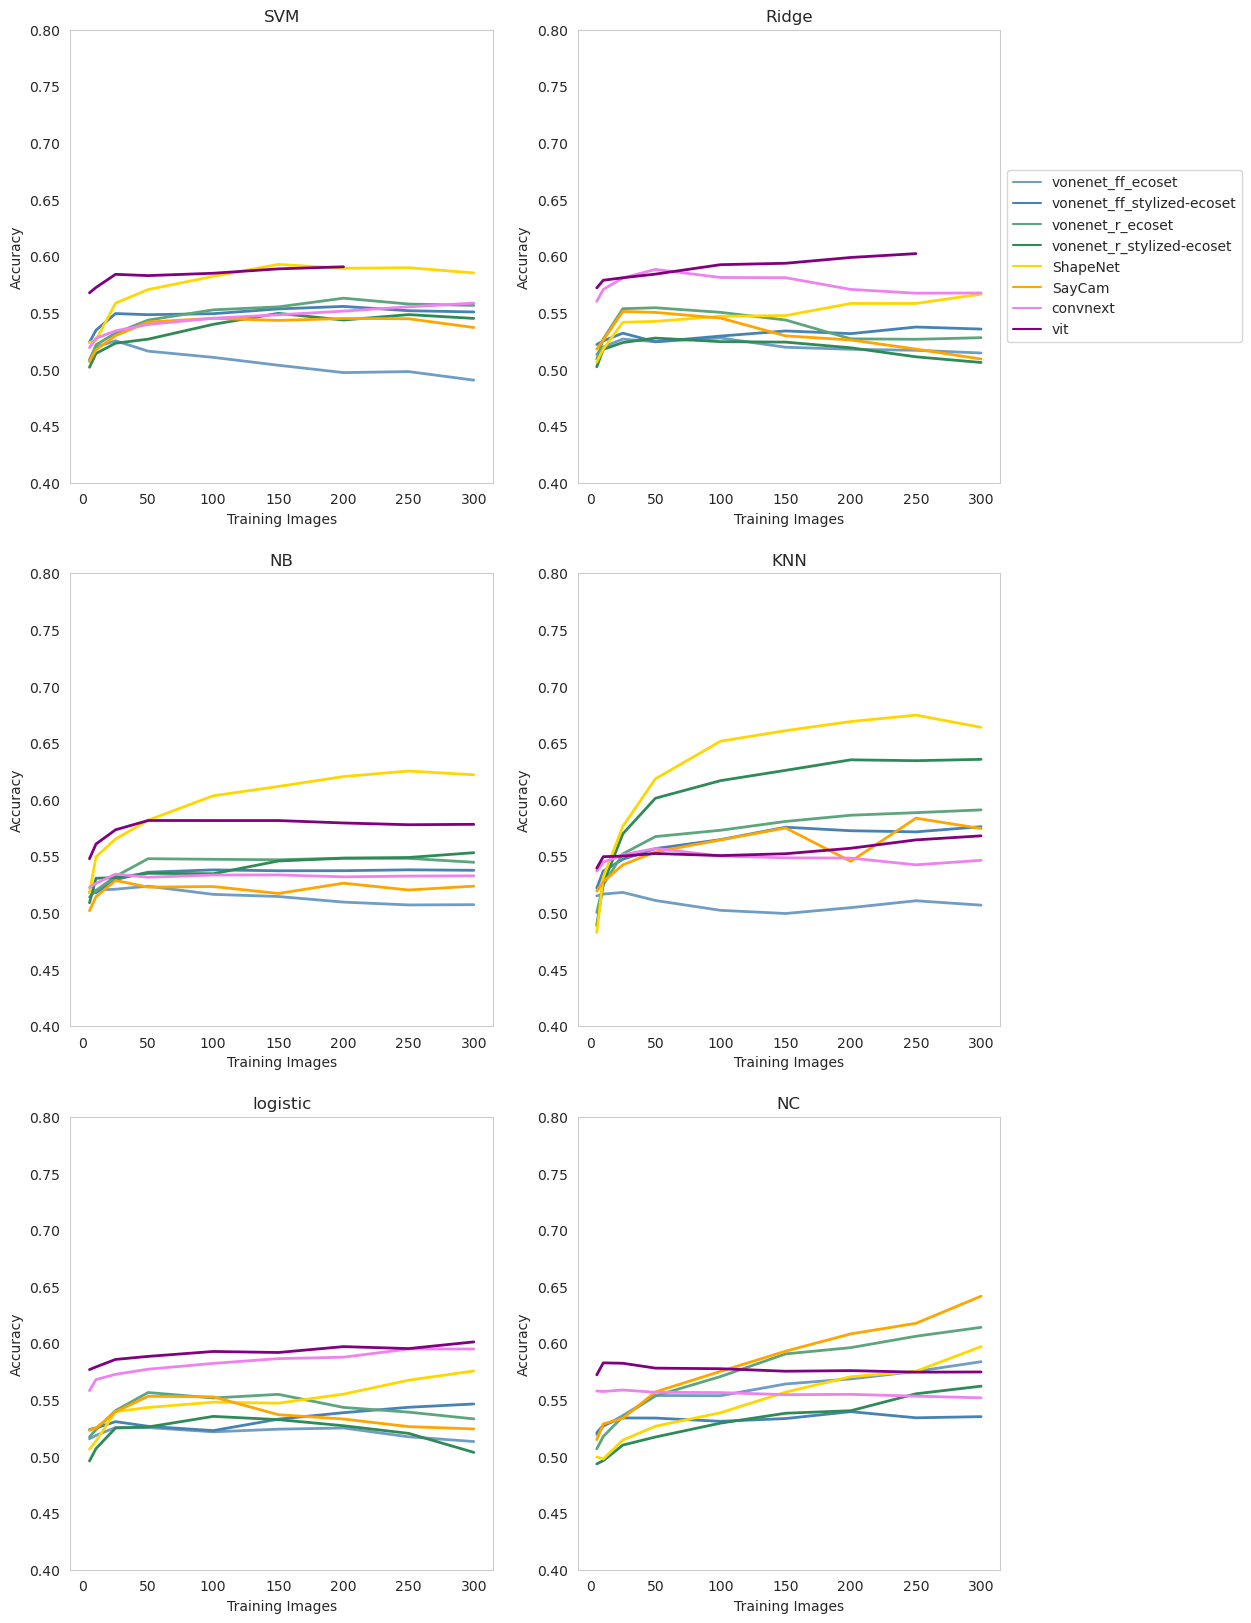

IC
no file for vit_SVM_300_IC
no file for vit_Ridge_300_IC


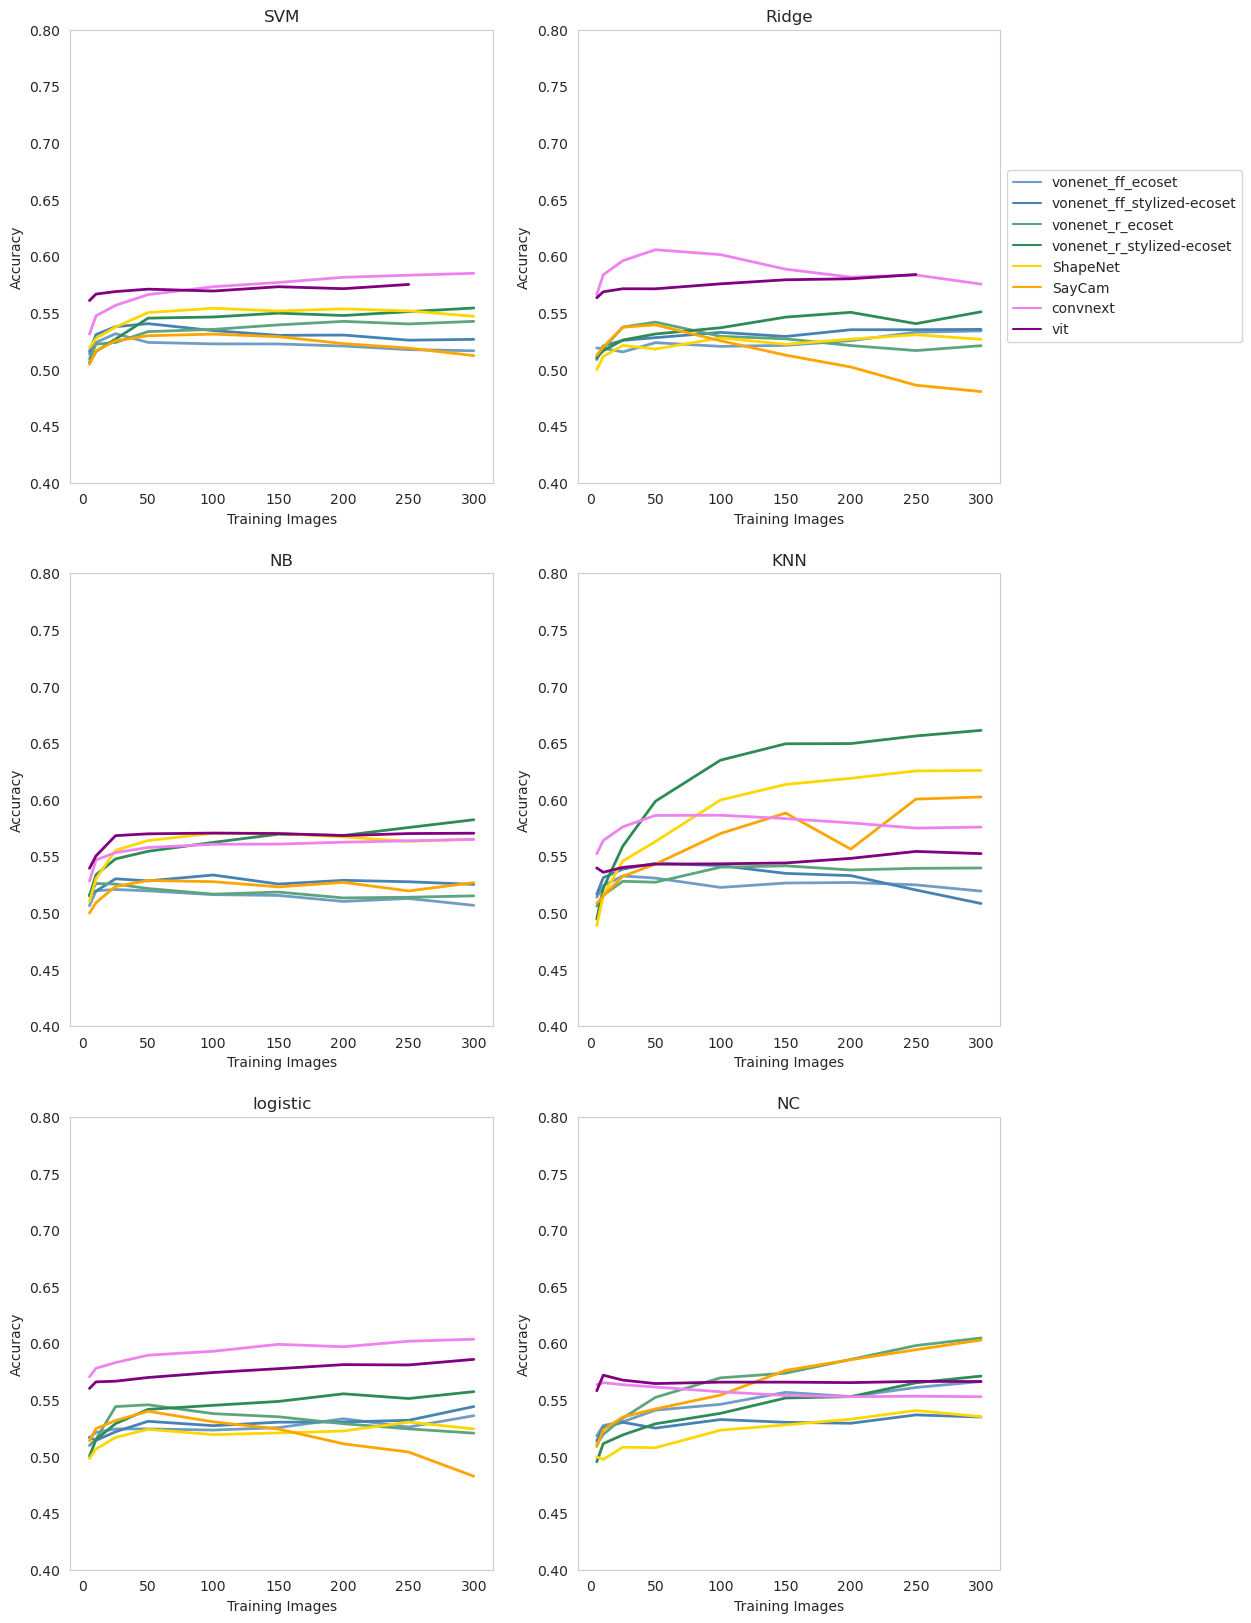

In [7]:
'''Make seperate line plots for each classifier showing model performance as a function of train_n'''

for cond in model_conds:
    print(cond)
    
    #loop through classifiers
    #create 3 x 2 subplot to plot each classifier data
    fig, ax = plt.subplots(3,2, figsize=(12,20))
    #set theme to be blank
    sns.set_style("whitegrid", {'axes.grid' : False})



    for classifier in classifiers:
        

        #add model data to one summary file
        summary_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc'])
        for model in model_arch:
            for train_n in train_ns:
                
                    model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                    if os.path.exists(model_file):
                        temp_df = pd.read_csv(model_file)

                        #groupby 
                        temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()
                        
                        summary_df = pd.concat([summary_df, temp_df_mean], axis = 0)
                    else:
                        print(f'no file for {model}_{classifier}_{train_n}_{cond}')


        #plot line plot in seaborn in each subplot
        sns.lineplot(data = summary_df, x = 'train_ims', y = 'acc', hue = 'model', errorbar= None, ax = ax.flatten()[classifiers.index(classifier)], 
                     linewidth = 2, palette=model_colors, legend = 'full')
        
        #add title
        ax.flatten()[classifiers.index(classifier)].set_title(classifier)
        #remove legend
        ax.flatten()[classifiers.index(classifier)].get_legend().remove()

        #set x axis to training images
        ax.flatten()[classifiers.index(classifier)].set_xlabel('Training Images')
        #set y axis to accuracy
        ax.flatten()[classifiers.index(classifier)].set_ylabel('Accuracy')

        #add ylim
        ax.flatten()[classifiers.index(classifier)].set_ylim(.4,.8)

        #add legend to second subplot
        if classifier == classifiers[1]:
            ax.flatten()[classifiers.index(classifier)].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    #save
    plt.savefig(f'{fig_dir}/{cond}_all_classifiers.png', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.pause(.001)

In [139]:
temp_df = pd.read_csv('/user_data/vayzenbe/GitHub_Repos/kornet/results/models/convnext_SVM_train150_testOutline.csv')

#groupby 
temp_df_mean1 = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()

temp_df_mean2 = temp_df.groupby(['model','classifier','train_ims','condition','acc']).mean().reset_index()

In [138]:
temp_df_mean1

,model,classifier,train_ims,condition,acc
0,convnext,SVM,150,Outline,0.636071


In [141]:
temp_df_mean2['acc'].mean()

0.7249999999999999